In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from SqueezeDetHelpers import get_all_points_from_prediction
from Models.PoolingAndFire import create_loss_function_multiple_detection
from PreProcess import *

In [3]:
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_complete_run_09.h5py")
MODEL_FILE = os.path.expanduser("~/results/SVPGestureRec/all_points_overfit_32.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [4]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

 11%|█         | 444/4126 [00:00<00:00, 4437.53it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


100%|██████████| 4126/4126 [00:00<00:00, 5169.22it/s]

In [5]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) * 10

NUM_CLASSES = 42

l = create_loss_function_multiple_detection(20,
                                            20,
                                            LABEL_WEIGHT,
                                            OFFSET_SCALE,
                                            OFFSET_LOSS_WEIGHT,
                                            NUM_CLASSES,
                                            EPSILON,
                                            BATCHSIZE)

In [6]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [7]:
samples_dir = VALIDATION_DIR
annotations_dir = VALIDATION_ANNOTATIONS
NUM_SAMPLES_TO_CHECK = 10

In [8]:
samples_to_check = []
for fi in os.listdir(samples_dir):
    if fi.endswith('png'):
        samples_to_check.append(int(fi.split('.')[0]))
        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
            break

print(samples_to_check)

[39255, 37303, 37656, 37244, 40921, 37184, 39166, 38639, 37728, 38312]


In [9]:
#labels, images = load_data_with_anchors(samples_to_check,
#                                        DATA_DIR,
#                                        ANNOTATIONS_PATH,
#                                        320, 320,
#                                        20, 20,
#                                        'png',
#                                        num_classes=NUM_CLASSES)

#overfit_sample = range(10)
#samples_to_check = overfit_sample
labels, images = load_data_with_anchors(samples_to_check,
                                        samples_dir,
                                        annotations_dir,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
for c, im in enumerate(images):
    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

print(np.max(images[0]))

0.5607843137254902


In [10]:

for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 0.12437500953674316
Offset max y: 0.07062501907348633

Offset max x: 0.065625
Offset max y: 0.11125001907348633

Offset max x: 0.0875
Offset max y: 0.134375

Offset max x: 0.12062501907348633
Offset max y: 0.053125

Offset max x: 0.08312501907348632
Offset max y: 0.060000038146972655

Offset max x: 0.0888124942779541
Offset max y: 0.05187501907348633

Offset max x: 0.09699997901916504
Offset max y: 0.05625

Offset max x: 0.10218749046325684
Offset max y: 0.05249996185302734

Offset max x: 0.12150001525878906
Offset max y: 0.08812503814697266

Offset max x: 0.09262499809265137
Offset max y: 0.10562496185302735

Offset max x: 0.11156249046325684
Offset max y: 0.08812503814697266

Offset max x: 0.13168749809265137
Offset max y: 0.07749996185302735

Offset max x: 0.06418747901916504
Offset max y: 0.09562501907348633

Offset max x: 0.10081248283386231
Offset max y: 0.11187496185302734

Offset max x: 0.07881250381469726
Offset max y: 0.125

Offset max x: 0.1398749

In [11]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [12]:
"""
for c, h in enumerate(right_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        print(f"Right hand point: ({p[0]}, {p[1]})")
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
    
for c, h in enumerate(left_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
"""

'\nfor c, h in enumerate(right_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        print(f"Right hand point: ({p[0]}, {p[1]})")\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n    \nfor c, h in enumerate(left_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n'

In [13]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.1647477388381958
Max processing time: 1.5012431144714355
Min processing time: 0.016010046005249023
Average processing time excepting first: 0.016248252656724717


In [14]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        print(len(label_points))
        
        for p in label_points:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            #print(f"Label point: ({x}, {y})")
            #print(f"\tOffset: ({p[2]}, {p[3]})")
            print(f"Label point: ({x}, {y}), offset: ({p[2]}, {p[3]})")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)
        

1
Label point: (95.9000015258789, 178.3000030517578), offset: (4.900001525878906, -3.6999969482421875)
1
Label point: (101.5, 169.8000030517578), offset: (-4.5, 2.8000030517578125)
1
Label point: (105.0, 173.5), offset: (-1.0, 6.5)
1
Label point: (110.30000305175781, 175.5), offset: (4.3000030517578125, -6.5)
1
Label point: (104.30000305175781, 176.60000610351562), offset: (-1.6999969482421875, -5.399993896484375)
1
Label point: (90.20999908447266, 160.3000030517578), offset: (-0.7900009155273438, -6.6999969482421875)
1
Label point: (91.5199966430664, 161.0), offset: (0.5199966430664062, -6.0)
1
Label point: (92.3499984741211, 160.39999389648438), offset: (1.3499984741210938, -6.600006103515625)
1
Label point: (95.44000244140625, 166.10000610351562), offset: (4.44000244140625, -0.899993896484375)
1
Label point: (74.81999969482422, 168.89999389648438), offset: (-1.1800003051757812, 1.899993896484375)
1
Label point: (77.8499984741211, 166.10000610351562), offset: (1.8499984741210938, -0.

0
0
0
0
0
0
0
0
0
0
1
Label point: (125.69999694824219, 184.60000610351562), offset: (4.6999969482421875, 2.600006103515625)
1
Label point: (124.5, 171.0), offset: (3.5, 4.0)
1
Label point: (123.0, 152.6999969482422), offset: (2.0, 0.6999969482421875)
1
Label point: (118.19999694824219, 132.39999389648438), offset: (-2.8000030517578125, -4.600006103515625)
1
Label point: (133.1999969482422, 207.60000610351562), offset: (-3.8000030517578125, -5.399993896484375)
1
Label point: (133.0, 193.10000610351562), offset: (-4.0, -4.899993896484375)
1
Label point: (131.1999969482422, 177.39999389648438), offset: (-5.8000030517578125, -4.600006103515625)
1
Label point: (127.19999694824219, 161.39999389648438), offset: (6.1999969482421875, -5.600006103515625)
1
Label point: (117.9000015258789, 212.1999969482422), offset: (-3.0999984741210938, -0.8000030517578125)
1
Label point: (117.5999984741211, 197.60000610351562), offset: (-3.4000015258789062, -0.399993896484375)
1
Label point: (117.800003051757

In [15]:
THRESHOLD = 0.9

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        max_val = np.max(pred[:,:,0])
        #max_val = 0.9
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=max_val,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            print(f"Predicted point: ({x}, {y}), confidence: {max_val}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Predicted point: (92.85879135131836, 108.94449377059937), confidence: 0.18432356417179108
Predicted point: (66.78307819366455, 298.3938865661621), confidence: 0.02172721177339554
Predicted point: (218.0000877380371, 265.0088768005371), confidence: 0.1534116268157959
Predicted point: (142.87370681762695, 68.53356178104877), confidence: 0.3194645047187805
Predicted point: (-98.07424187660217, 83.06487338338047), confidence: 0.9878359436988831
Predicted point: (221.7848358154297, 79.13558292388916), confidence: 0.007189783733338118
Predicted point: (198.1459197998047, 78.46663761138916), confidence: 0.38284197449684143
Predicted point: (16.384382247924805, 138.5994701385498), confidence: 0.272087037563324
Predicted point: (-78.85822296142578, 74.82965338230133), confidence: 0.3275160491466522
Predicted point: (215.74382781982422, 373.9559440612793), confidence: 0.7447436451911926
Predicted point: (171.60247421264648, 207.4921588897705), confidence: 0.09309902787208557
Predicted point: (19

Predicted point: (125.43781089782715, 42.12723350524902), confidence: 0.0006201399955898523
Predicted point: (-61.698851585388184, -39.53221797943115), confidence: 0.002722424454987049
Predicted point: (163.63140106201172, 175.79952383041382), confidence: 0.00034937047166749835
Predicted point: (216.73022842407227, 142.36937427520752), confidence: 0.00223425286822021
Predicted point: (70.75971603393555, 111.89728927612305), confidence: 0.004593148361891508
Predicted point: (154.63617515563965, -38.823975563049316), confidence: 0.0048212334513664246
Predicted point: (13.824825286865234, 71.73233032226562), confidence: 0.0010165461571887136
Predicted point: (256.8015556335449, 37.98742866516113), confidence: 0.0004774788685608655
Predicted point: (-0.9507040977478027, 223.81330108642578), confidence: 0.0015379383694380522
Predicted point: (246.47078704833984, 211.47521591186523), confidence: 0.002936899196356535
Predicted point: (-129.9984971313097, 19.85701560974121), confidence: 0.0041

Predicted point: (150.54822158813477, -6.100200653076172), confidence: 0.0007973614847287536
Predicted point: (35.14748764038086, 181.42211532592773), confidence: 0.0007974575855769217
Predicted point: (64.80036664009094, 33.58813714981079), confidence: 0.0002677599259186536
Predicted point: (46.24784183502197, 194.218994140625), confidence: 0.0028191774617880583
Predicted point: (133.23755264282227, 141.30056190490723), confidence: 0.0029694181866943836
Predicted point: (183.78817749023438, 48.57606506347656), confidence: 0.0001889815175672993
Predicted point: (51.32748317718506, 100.6306037902832), confidence: 0.0009211672004312277
Predicted point: (70.1491756439209, 151.10487270355225), confidence: 0.000393410911783576
Predicted point: (63.19087219238281, 219.22040557861328), confidence: 0.006012343801558018
Predicted point: (206.22557830810547, -40.628570556640625), confidence: 0.0038295176345854998
Predicted point: (262.6661796569824, 14.062295913696289), confidence: 0.00102854939

In [16]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [ 5 11]
prediction_point: [ 3 16]
5.385164807134504

label_point: [ 6 10]
prediction_point: [12 13]
6.708203932499369

label_point: [ 6 10]
prediction_point: [ 3 13]
4.242640687119285

label_point: [ 6 11]
prediction_point: [ 3 14]
4.242640687119285

label_point: [ 6 11]
prediction_point: [ 3 15]
5.0

label_point: [ 5 10]
prediction_point: [ 4 14]
4.123105625617661

label_point: [ 5 10]
prediction_point: [ 4 14]
4.123105625617661

label_point: [ 5 10]
prediction_point: [ 3 14]
4.47213595499958

label_point: [ 5 10]
prediction_point: [ 3 14]
4.47213595499958

label_point: [ 4 10]
prediction_point: [ 3 15]
5.0990195135927845

label_point: [ 4 10]
prediction_point: [ 4 15]
5.0

label_point: [ 4 10]
prediction_point: [ 3 15]
5.0990195135927845

label_point: [ 5 10]
prediction_point: [ 3 15]
5.385164807134504

label_point: [ 5 11]
prediction_point: [ 3 15]
4.47213595499958

label_point: [ 5 11]
prediction_point: [ 3 15]
4.47213595499958

label_point: [ 4 11]
prediction_point: [

233.32719174279597

In [17]:
p1 = np.array([9, 13])
p2 = np.array([10, 11])
print(np.linalg.norm(p1-p2))

2.23606797749979


In [18]:
def accuracy():
    pass

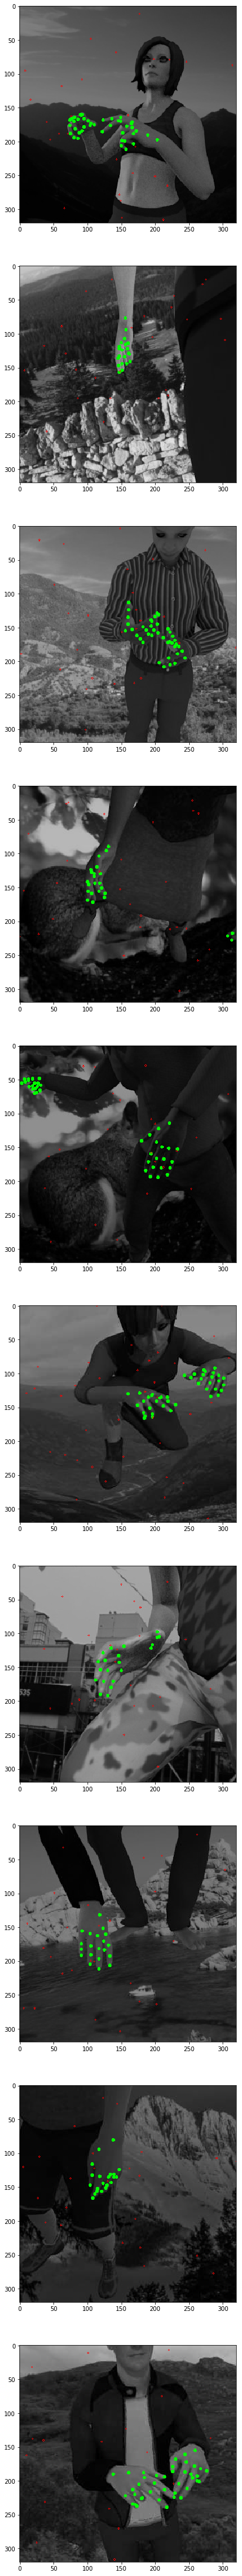

In [19]:
f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")

#f = plt.figure(figsize=(20, 20))
#plt.imshow(images_show[0], cmap='gray')